<a href="https://colab.research.google.com/github/abhaysinghhh/aerialimagesegmentation/blob/main/Aerial_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up colab gpu runtime environment
Install required libraries

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=4b1ac36f718d8e25783c126bedd7f8642ac2ee07016b701c9d6e4e62882b52e7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9f55b8c26abf6832cb724d06265bc741aa86efc7547b220465c535cb8cc1396d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Dataset

Here the dataset which we are going to use in this project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

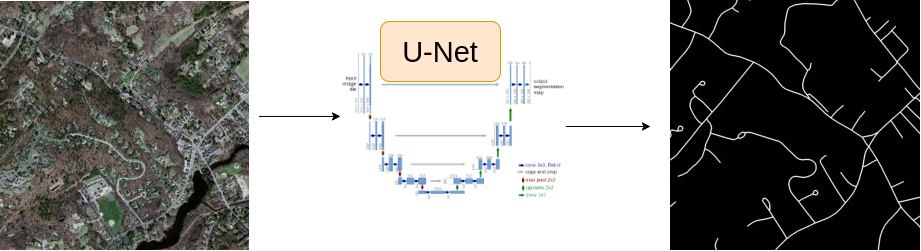

# Download Subset Dataset

In [3]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 18.30 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setup Configurations

In [6]:
CSV_FILE = "/content/Road_seg_dataset/train.csv"
DATA_DIR = "/content/Road_seg_dataset/"

DEVICE = 'cuda'

EPOCHS = 15
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [8]:
idx = 2
row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.COLOR_BGR2RGB)

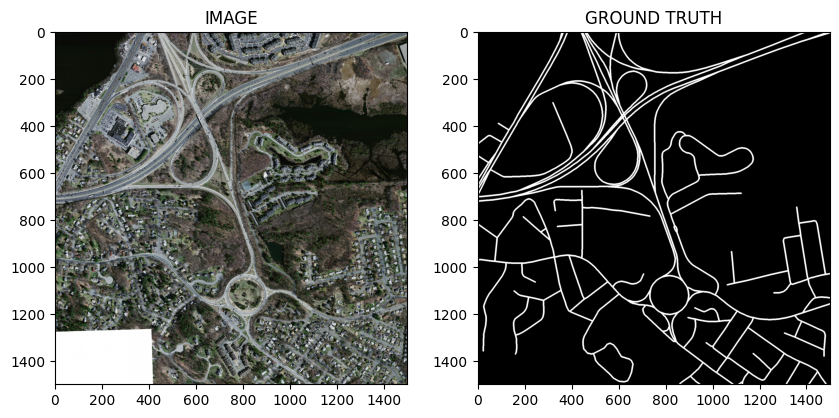

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df,test_size = 0.20,random_state = 42)

# Augmentation Functions

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMG_SIZE,IMG_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([A.Resize(IMG_SIZE,IMG_SIZE)])

# Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
from albumentations import augmentations
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #(h,w)
    mask = np.expand_dims(mask,axis = -1) #(h,w,c)

    if self.augmentations:
      data = self.augmentations(image = image,mask = mask)
      image = data['image'] #(hieght,width,channel)
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)#(c,h,w)

    image =torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image,mask

In [15]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

In [16]:
print(len(trainset))
print(len(validset))

159
40


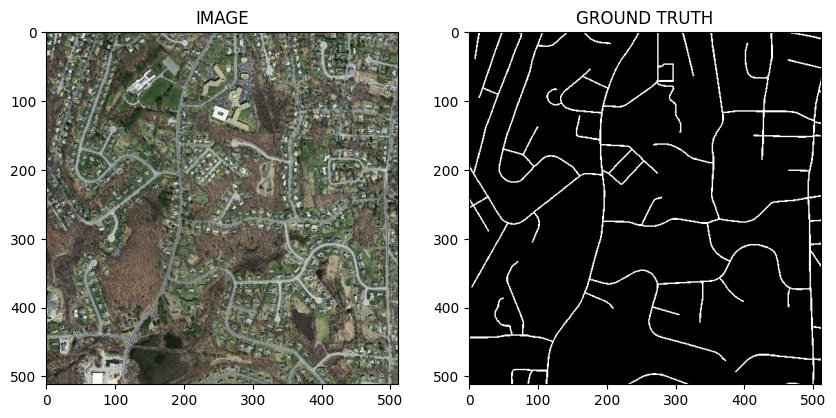

In [17]:
idx = 31
image, mask = trainset[idx]
helper.show_image(image,mask)

torch.Tensor

# Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

print(len(trainloader))
print(len(validloader))

20
5


In [20]:
for images, masks in trainloader:
  print(f"One batch image shape : {images.shape}")
  print(f"One batch mask shape : {mask.shape}")
  break

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([1, 512, 512])


# Create Segmentation Model

In [21]:
#from segmentation_models_pytorch.base.model import SegmentationModel
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights =  WEIGHTS,
        in_channels=3,
        classes = 1,
        activation = None
    )

  def forward(self,images,masks = None):
    logits = self.backbone(images)

    if masks!=None:
      return logits, DiceLoss(mode = 'binary')(logits,masks) + nn.BCEWithLogitsLoss()(logits,masks)

    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:02<00:00, 8.56MB/s]


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Create Train and Validation Function

In [24]:
def train_fn(dataloader,model,optimizer):
  model.train() #turn ON dropout,batchnorm etc.

  total_loss = 0.00
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()

  return total_loss/len(dataloader)

In [25]:
def eval_fn(dataloader,model):
  model.eval() #turn OFF dropout,batchnorm etc.

  total_loss = 0.00

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images,masks)

      total_loss+=loss.item()

  return total_loss/len(dataloader)

# Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [27]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss<best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("SAVED-MODEL")
    best_loss = valid_loss
  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


SAVED-MODEL
Epoch : 1 Train Loss : 1.1644472867250442 Valid Loss : 1.0839245796203614


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch : 2 Train Loss : 0.8046598881483078 Valid Loss : 1.3776740312576294


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epoch : 3 Train Loss : 0.7347172617912292 Valid Loss : 0.8785029768943786


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


SAVED-MODEL
Epoch : 4 Train Loss : 0.6911776036024093 Valid Loss : 0.7181815266609192


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch : 5 Train Loss : 0.6675515025854111 Valid Loss : 0.7485000371932984


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


SAVED-MODEL
Epoch : 6 Train Loss : 0.6632575690746307 Valid Loss : 0.6995281338691711


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch : 7 Train Loss : 0.6397599428892136 Valid Loss : 0.7791520833969117


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epoch : 8 Train Loss : 0.6427211672067642 Valid Loss : 0.688871955871582


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 9 Train Loss : 0.6434448033571243 Valid Loss : 0.7013047695159912


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


SAVED-MODEL
Epoch : 10 Train Loss : 0.6398544132709503 Valid Loss : 0.6846787929534912


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch : 11 Train Loss : 0.6354245662689209 Valid Loss : 0.7265761733055115


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epoch : 12 Train Loss : 0.6273236453533173 Valid Loss : 0.6820536613464355


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 13 Train Loss : 0.6117662400007248 Valid Loss : 0.6970884323120117


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


SAVED-MODEL
Epoch : 14 Train Loss : 0.6175333082675933 Valid Loss : 0.6620709538459778


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

SAVED-MODEL
Epoch : 15 Train Loss : 0.6073715925216675 Valid Loss : 0.6466299772262574


# Inference

In [28]:
idx = 24

model.load_state_dict(torch.load("/content/best-model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w)->(b,c,h,w)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

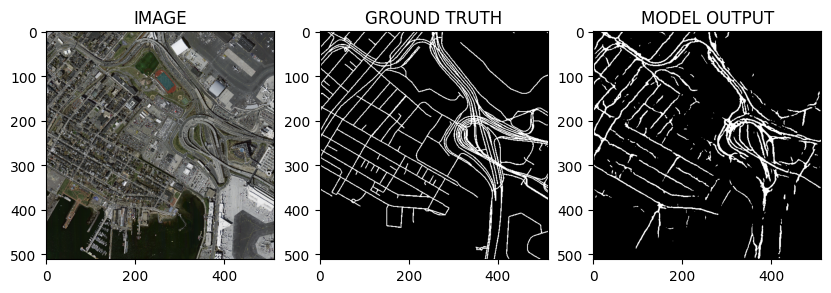

In [29]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

### Model Evaluation

In [57]:
def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places


mask1 = mask.numpy()
pred1 = pred_mask.cpu().detach().numpy()
print(accuracy(mask1,pred1))

0.966


In [60]:
j=0
io = 0
for i in validset:
  image,mask = i
  logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w)->(b,c,h,w)

  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > 0.5)*1.0
  mask1 = mask.numpy()
  pred1 = pred_mask.cpu().detach().numpy()
  j+=accuracy(mask1,pred1)
  io+=dice_coef(mask1,pred1)
print("ACCURACY:",j/len(validset), ", Dice Similarity:", io/len(validset))


ACCURACY: 0.9543749999999998 , Dice Similarity: 0.5221750000000001
